# 3D Gaussian Mask Generation Notebook

In [12]:
import sys
sys.dont_write_bytecode = True

import torch 
import numpy as np 
from matplotlib import pyplot as plt
from plyfile import PlyData
from projection.projections import camera_to_image, world_to_camera, filter_pixel_points, get_3D_indices
from util.view import Viewset

### Constants

In [13]:
GAUSSIAN_FILE = './projection/point_cloud/iteration_30000/point_cloud.ply' 
CAMERAS_JSON = './projection/cameras.json'
IMAGE_PATH = './dataset/truck/images/'

# sampling radius for mapping 2D prompts to 3D gaussians
EPS = 10

### Input variables

In [14]:
init_view_index = 15

init_prompts = torch.tensor([[380, 250], [700, 260], [550, 230]]).T

# create masks from a random subset of views if rate < 1
view_sampling_rate = 0.5

***
# 1. Initialization

### Load Gaussians

In [15]:
pcd = PlyData.read(GAUSSIAN_FILE)['vertex']
pcd_array = np.array([pcd['x'], pcd['y'], pcd['z']], dtype=np.double).T
opacities = pcd['opacity']

pcd_array = torch.from_numpy(pcd_array)
opacities = torch.from_numpy(opacities)

### Load views and show input prompts

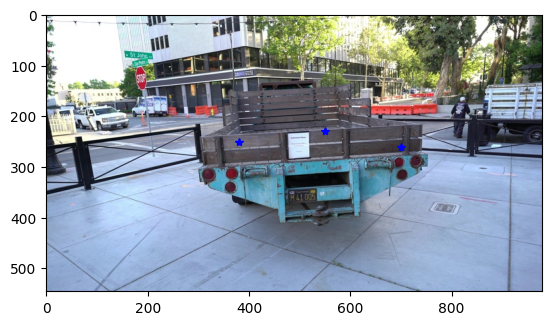

In [16]:
views = Viewset(camera_json=CAMERAS_JSON, dataset_path=IMAGE_PATH)

init_view = views.get(init_view_index)

plt.imshow(init_view.image)
plt.plot(init_prompts[0,:], init_prompts[1,:], 'b*')
plt.show()

### Map 2D input points to 3D Gaussians

In [17]:
init_projection = init_view.project(pcd_array)

# scale user points in case image mismatches sizes defined in cameras.json
user_points = init_view.scale_from_image(init_prompts)

pcd_indices = get_3D_indices(init_projection.coords, init_projection.depths, 
                             init_projection.indices, user_points, EPS, opacities)

prompt_gaussians = pcd_array[pcd_indices, :] 

print(prompt_gaussians) 

Point 1: 
	 Depth: 2.3526742028762913
	 (x,y) => tensor([756, 505], dtype=torch.int32)
Point 2: 
	 Depth: 2.465981473265354
	 (x,y) => tensor([1403,  517], dtype=torch.int32)
Point 3: 
	 Depth: 2.391784046164558
	 (x,y) => tensor([1096,  462], dtype=torch.int32)
tensor([[2.8123, 0.4185, 0.0323],
        [2.7469, 0.2980, 1.3799],
        [2.7844, 0.2547, 0.7111]], dtype=torch.float64)


***
# 2. Creating Masks from Prompts

load model

In [18]:
from sam.sam import SAM

sam = SAM("./sam/sam_vit_h_4b8939.pth")


Loading pth...

DONE


Helper function

In [19]:
def predict_mask_from_view(prompt_gaussians, view):
    points, labels = view.project(prompt_gaussians).to_sam_input(view.scale)
    if points.shape[0] == 0:
        # handle cases when none of the prompt gaussians are in view
        return None

    mask_view, _, _ = sam.predict(view.image, points, labels, multimask=False)

    return mask_view[0], points

### Show mask from initial user prompts (FOR DEBUGGING ONLY)

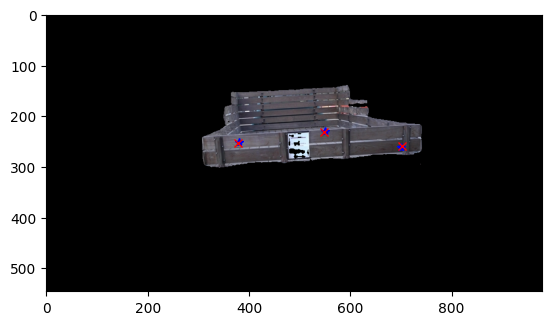

In [20]:
mask, projected_points = predict_mask_from_view(prompt_gaussians, init_view)

plt.imshow(mask[:,:,np.newaxis] * init_view.image)
# red x marks 3d-to-2d projections, blue * marks original 2d input
plt.plot(init_prompts[0,:], init_prompts[1,:], 'b*')
plt.plot(projected_points[:, 0], projected_points[:, 1], 'rx')
plt.show()

### Create Masks from multiple views

Create masks from a subset of all views, based on `view_sampling_rate`. Results are stored in `results`

In [21]:
from tqdm import tqdm

views_subset = views.sample(view_sampling_rate)

# results is a list of result sublist each containing [view, mask, prompt_point_pos]
results = []

# track views that do not contain the prompt points
missing_view_indices = []

for view in tqdm(views_subset):
    result = predict_mask_from_view(prompt_gaussians, view)

    if result is not None:
        results.append([view, *result])
    else:
        missing_view_indices.append(view.index)

print("Views containing no visible prompt points:", missing_view_indices)

100%|██████████| 126/126 [04:20<00:00,  2.07s/it]

Views containing no visible prompt points: [184, 44, 153, 43, 118, 220, 202, 236, 205, 185, 45, 42, 117, 40, 237, 222, 150, 182, 223, 119]


### Visualize all result masks

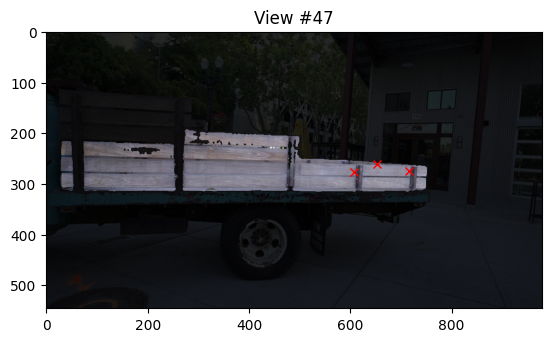

In [44]:
for view, mask, points in results:
    plt.title(f"View #{view.index}")

    # composites mask with original image, showing faint masked areas
    plt.imshow(np.round(np.clip(mask[:,:,np.newaxis], 0.15, 1, dtype=float) * view.image).astype(int)) 
    plt.plot(points[:,0], points[:,1], 'rx')
    plt.show()